# HW4-3: Enhance DQN for random mode With Training Tips

## Prompt

Using [hw4-1.ipynb](hw4-1.ipynb) as a reference, perform the following modifications:
- Retain only the code required for the improved version of Program 3.5 (程式 3.5 改良版).
- Convert the code to the PyTorch Lightning format.
- Add an extra linear layer in the model to improve accuracy.
- Add a learning rate scheduler that reduces the learning rate by 0.5 at 4/5 of the total epochs for final fine-tuning.

## Reply

This notebook refactors the DQN Gridworld agent to use PyTorch Lightning for cleaner training and modularity.

In [1]:
import random
from collections import deque
import numpy as np
import torch
import pytorch_lightning as pl
from Gridworld import Gridworld
from IPython.display import clear_output
from matplotlib import pylab as plt

# Download required Gridworld files
!wget -qnc https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/Gridworld.py
!wget -qnc https://github.com/DeepReinforcementLearning/DeepReinforcementLearningInAction/raw/master/Errata/GridBoard.py

zsh:1: command not found: wget
zsh:1: command not found: wget


### Action mapping

In [2]:
action_set = {
    0: 'u',  # Up
    1: 'd',  # Down
    2: 'l',  # Left
    3: 'r'   # Right
}
move_pos = [(-1,0), (1,0), (0,-1), (0,1)]  # Move vectors for u,d,l,r

### Convert model to LightningModule

In [3]:
class DQNLightning(pl.LightningModule):
    def __init__(self, lr=1e-3, gamma=0.9, mem_size=1000, batch_size=200, epochs=5000):
        super().__init__()
        self.save_hyperparameters()
        L1, L2, L3, L4, L5= 64, 128, 256, 128, 4
        self.model = torch.nn.Sequential(
            torch.nn.Linear(L1, L2),
            torch.nn.ReLU(),
            torch.nn.Linear(L2, L3),
            torch.nn.ReLU(),
            torch.nn.Linear(L3, L4),
            torch.nn.ReLU(),
            torch.nn.Linear(L4, L5)
        )
        self.loss_fn = torch.nn.MSELoss()
        self.gamma = gamma
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.epochs = epochs
        self.replay = deque(maxlen=mem_size)
        self.epsilon = 1.0
        self.max_moves = 50
        self.losses = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.hparams.epochs * 4 // 5,
            gamma=0.5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        device = self.device
        game = Gridworld(size=4, mode='random')
        state1_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
        state1 = torch.from_numpy(state1_).float().to(device)
        status = 1
        mov = 0
        while status == 1:
            mov += 1
            qval = self(state1)
            qval_ = qval.data.cpu().numpy()
            if random.random() < self.epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)
            hit_wall = game.validateMove('Player', move_pos[action_]) == 1
            action = action_set[action_]
            game.makeMove(action)
            state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/100.0
            state2 = torch.from_numpy(state2_).float().to(device)
            reward = -5 if hit_wall else game.reward()
            done = True if reward != -1 else False
            exp = (state1, action_, reward, state2, done)
            self.replay.append(exp)
            state1 = state2
            if abs(reward) == 10 or mov > self.max_moves:
                status = 0
                mov = 0

        # Experience replay
        if len(self.replay) > self.batch_size:
            minibatch = random.sample(self.replay, self.batch_size)
            state1_batch = torch.cat([s1.to(device) for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.tensor([a for (s1,a,r,s2,d) in minibatch], device=device)
            reward_batch = torch.tensor([r for (s1,a,r,s2,d) in minibatch], dtype=torch.float32, device=device)
            state2_batch = torch.cat([s2.to(device) for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.tensor([d for (s1,a,r,s2,d) in minibatch], dtype=torch.float32, device=device)
            Q1 = self(state1_batch)
            with torch.no_grad():
                Q2 = self(state2_batch)
            Y = reward_batch + self.gamma * ((1 - done_batch) * torch.max(Q2, dim=1)[0])
            X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = self.loss_fn(X, Y.detach())
            self.losses.append(loss.item())
            if self.epsilon > 0.1:
                self.epsilon -= (1/self.epochs)
            self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
            return loss
        else:
            return None

    def train_dataloader(self):
        # Dummy DataLoader to satisfy Lightning, batch is not used
        from torch.utils.data import DataLoader, TensorDataset
        dummy = torch.zeros(1)
        return DataLoader(TensorDataset(dummy), batch_size=1)

### Train the model

In [4]:
model = DQNLightning()
trainer = pl.Trainer(max_epochs=5000, enable_checkpointing=False, logger=False, enable_progress_bar=True, log_every_n_steps=100)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 74.8 K | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
74.8 K    Trainable params
0         Non-trainable params
74.8 K    Total params
0.299     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/Users/young/Documents/nchu-2025-spring/DRL/hw3/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]        

/Users/young/Documents/nchu-2025-spring/DRL/hw3/venv/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...
/Users/young/Documents/nchu-2025-spring/DRL/hw3/venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 66.77it/s, train_loss_step=0.364, train_loss_epoch=0.364]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 4999: 100%|██████████| 1/1 [00:00<00:00, 61.72it/s, train_loss_step=0.364, train_loss_epoch=0.364]


### Plot training losses

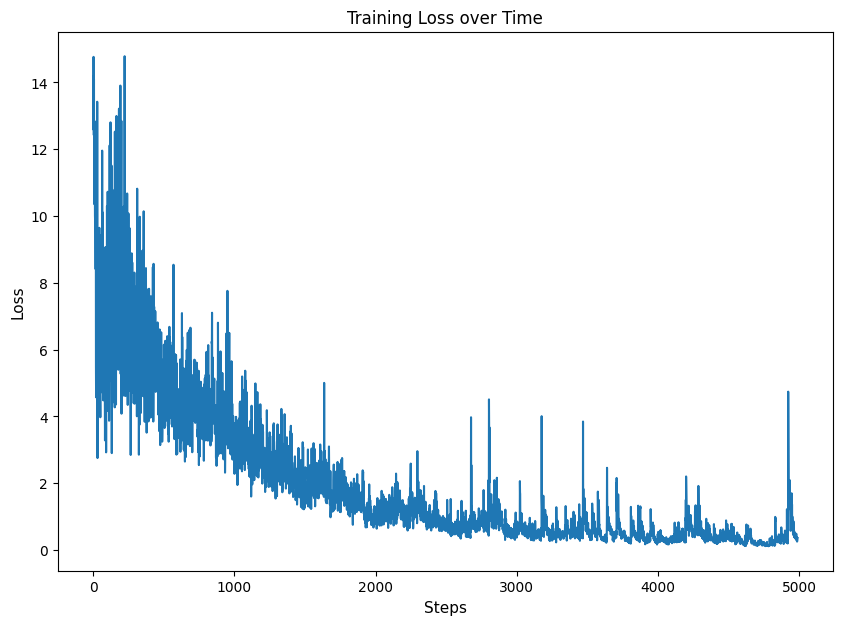

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(model.losses)
plt.xlabel("Steps", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.title("Training Loss over Time")
plt.show()

### Create a test function to evaluate model performance

In [6]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode)
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) 
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % reward)
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % reward)
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break    
    win = True if status == 2 else False
    return win

### Evaluate model

In [7]:
max_games = 1000
wins = 0
for i in range(max_games):
    if i % 100 == 0:
        print(f"Testing game {i}/{max_games}")
    win = test_model(model, mode='random')
    if win:
        wins += 1

Testing game 0/1000
Initial State:
[[' ' ' ' ' ' '+']
 ['-' 'P' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: r
[[' ' ' ' ' ' '+']
 ['-' ' ' 'P' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' 'P']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: u
[[' ' ' ' ' ' '+']
 ['-' ' ' ' ' ' ']
 ['W' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
Initial State:
[[' ' ' ' ' ' ' ']
 ['-' ' ' ' ' 'P']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' ' ']
 ['-' ' ' 'P' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[[' ' ' ' ' ' ' ']
 ['-' ' ' ' ' ' ']
 [' ' ' ' '+' 'W']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10
Initial State:
[['P' '-' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[[' ' '-' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' '+' ' ']
 ['W' ' ' ' ' ' ']]
Move #: 1; Taking action: r
[[' 

In [8]:
win_perc = float(wins) / float(max_games)
print(f"Games played: {max_games}, # of wins: {wins}")
print(f"Win percentage: {100.0*win_perc:.2f}%")

Games played: 1000, # of wins: 969
Win percentage: 96.90%
